# Simpsons Classifier With Little VGG

## Importing Libraries

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import ELU

In [3]:
num_classes = 20
img_rows = 32
img_cols = 32
batch_size = 16

train_data_dir = "./Classifier/simpsons/train"
val_data_dir = "./Classifier/simpsons/validation"

#Lets use some data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_rows, img_cols),
                                                    batch_size = batch_size,
                                                    class_mode = "categorical")

validation_generator = validation_datagen.flow_from_directory(val_data_dir,
                                                              target_size = (img_rows, img_cols),
                                                              batch_size = batch_size,
                                                              class_mode = "categorical")

Found 19548 images belonging to 20 classes.
Found 990 images belonging to 20 classes.


# Create Little VGG Model

In [20]:
model = Sequential()

#First Conv- Relu Layer

model.add(Conv2D(64,(3,3),input_shape = (img_rows, img_cols, 3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#2nd Conv-Relu Layer

model.add(Conv2D(64,(3,3),input_shape = (img_rows, img_cols, 3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#MaxPooling with Dropout
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#3rd Conv-Relu 
model.add(Conv2D(128,(3,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#4th Conv-Relu
model.add(Conv2D(128,(3,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#MaxPooling with Dropout
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#5th Conv-Relu
model.add(Conv2D(256,(3,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#6th Conv-Relu
model.add(Conv2D(256,(3,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#MaxPooling with Dropout
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#1st FC Layer
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#2nd FC layer
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Final Dense Layer
model.add(Dense(num_classes))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)       

In [17]:
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

In [23]:

#generate the plot

plot_model(model,to_file = "little_vgg_cnn_model.png",
           show_shapes = True,
           show_layer_names = True)

img = mpimg.imread("little_vgg_cnn_model.png")
plt.figure(figsize = (30,15))
imgplot = plt.imshow(img)
print(imgplot)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


FileNotFoundError: [Errno 2] No such file or directory: 'little_vgg_cnn_model.png'

# Training Little VGG model

In [26]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint("simpsons_little_vgg.h5",
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = "val_loss",
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks = [checkpoint, earlystop, reduce_lr]


model.compile(loss = "categorical_crossentropy",
              optimizer = Adam(lr = 0.01),
              metrics = ["accuracy"])


nb_train_samples = 19548
nb_val_samples = 990
epochs = 10
batch_size = 64

history = model.fit_generator(train_generator,
                              steps_per_epoch = nb_train_samples//batch_size,
                              epochs = epochs,
                              callbacks = callbacks,
                              validation_data = validation_generator,
                              validation_steps = nb_val_samples//batch_size)

/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-28 03:09:40.999048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-28 03:09:41.064927: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2194805000 Hz


Epoch 1/10
  1/305 [..............................] - ETA: 25:06 - loss: 4.6470 - accuracy: 0.0000e+00

2021-09-28 03:09:46.098176: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20054016 exceeds 10% of free system memory.
2021-09-28 03:09:46.149479: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18284544 exceeds 10% of free system memory.
2021-09-28 03:09:46.149619: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18284544 exceeds 10% of free system memory.
2021-09-28 03:09:46.179452: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28311552 exceeds 10% of free system memory.


  2/305 [..............................] - ETA: 1:50 - loss: 4.9097 - accuracy: 0.0000e+00 

2021-09-28 03:09:46.496060: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20054016 exceeds 10% of free system memory.


305/305 [==============================] - 120s 380ms/step - loss: 3.3190 - accuracy: 0.1277 - val_loss: 3.0672 - val_accuracy: 0.1167

Epoch 00001: val_loss improved from inf to 3.06718, saving model to simpsons_little_vgg.h5
Epoch 2/10
305/305 [==============================] - 115s 377ms/step - loss: 2.6299 - accuracy: 0.2018 - val_loss: 2.7742 - val_accuracy: 0.1958

Epoch 00002: val_loss improved from 3.06718 to 2.77420, saving model to simpsons_little_vgg.h5
Epoch 3/10
305/305 [==============================] - 108s 352ms/step - loss: 2.4482 - accuracy: 0.2543 - val_loss: 2.4708 - val_accuracy: 0.2042

Epoch 00003: val_loss improved from 2.77420 to 2.47079, saving model to simpsons_little_vgg.h5
Epoch 4/10
305/305 [==============================] - 106s 346ms/step - loss: 2.3396 - accuracy: 0.2910 - val_loss: 2.4017 - val_accuracy: 0.2875

Epoch 00004: val_loss improved from 2.47079 to 2.40166, saving model to simpsons_little_vgg.h5
Epoch 5/10
305/305 [===========================

# Performance Analysis

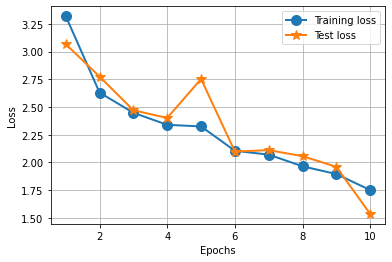

In [27]:
##plotting the loss Chart

import matplotlib.pyplot as plt
import numpy as np

history_dict = history.history

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

line1 = plt.plot(epochs, loss_values, label = "Training loss")
line2 = plt.plot(epochs, val_loss_values, label = "Test loss")

plt.setp(line1, linewidth = 2.0, marker = "o", markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = "*", markersize = 10.0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid("True")
plt.legend()
plt.show()

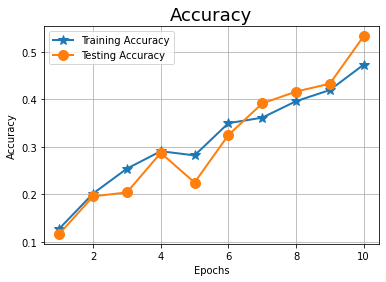

In [28]:
#plotting Accuracy

acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]

epochs = range(1,len(acc_values)+1)

line1 = plt.plot(epochs, acc_values, label = "Training Accuracy")
line2 = plt.plot(epochs, val_acc_values, label = "Testing Accuracy")

plt.setp(line1, linewidth = 2, marker = "*", markersize = 10)
plt.setp(line2, linewidth = 2, marker = "o", markersize = 10)
plt.title("Accuracy",fontsize = 18)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [33]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

batch_size = 16

#recreating validation generator with shuffle = False
validation_generator = validation_datagen.flow_from_directory(val_data_dir,
                                                              target_size = (32,32),
                                                              batch_size = batch_size,
                                                              class_mode = "categorical",
                                                              shuffle = False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k,v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 19548
nb_val_samples = 990


#confusion matrix and classification_report

y_pred = model.predict_generator(validation_generator, nb_val_samples//batch_size+1)
Y_pred = np.argmax(y_pred, axis = 1)

print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, Y_pred))
print("")
print("Classification Report")
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, Y_pred, target_names = target_names))


Found 990 images belonging to 20 classes.
Confusion Matrix
[[34  1  0  1  0  0  0  3  1  0  0  0  1  0  0  1  1  0  1  4]
 [ 0 46  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  3]
 [ 0  1  6  1  0  0  0  4  5  0  0 22  2  0  0  1  1  0  4  3]
 [ 0  0  0 18  3  0  0  1  4  1  0  2  3  0  1  1  0  0  2 12]
 [ 0  0  0  1 38  0  0  0  3  1  0  0  1  0  0  0  0  0  6  0]
 [ 4  2  2  1  6  1  3  1  4  3  0  0  2  0  0  3  0  0 13  4]
 [ 1  5  0  0  0  0 31  0  1  0  0  1  2  0  0  0  1  0  0  8]
 [10  0  0  1  0  0  7 19  4  1  0  0  2  0  0  0  3  0  0  3]
 [ 0  1  0  0  1  0  0  0 46  0  0  0  1  0  0  0  0  0  0  1]
 [ 0  2  0  0  0  0  0  0  3 45  0  0  0  0  0  0  0  0  0  0]
 [ 2  3  2  2  0  0  9  1  1  0  0  1  1  0  0  0  7  0  2 19]
 [ 4  0  5  0  0  0  1  2  8  1  0 27  0  0  0  0  0  0  1  1]
 [ 0  3  0  0  0  0  0  1  0  0  0  0 45  0  0  0  0  0  0  1]
 [ 1  1  0  1  0  0  3  1  2  0  0  0  0  1  0  1  0  0 13 26]
 [ 0  4  0  2  0  0  1  0  4  1  0  0 17  0 18  1  0  0  1 

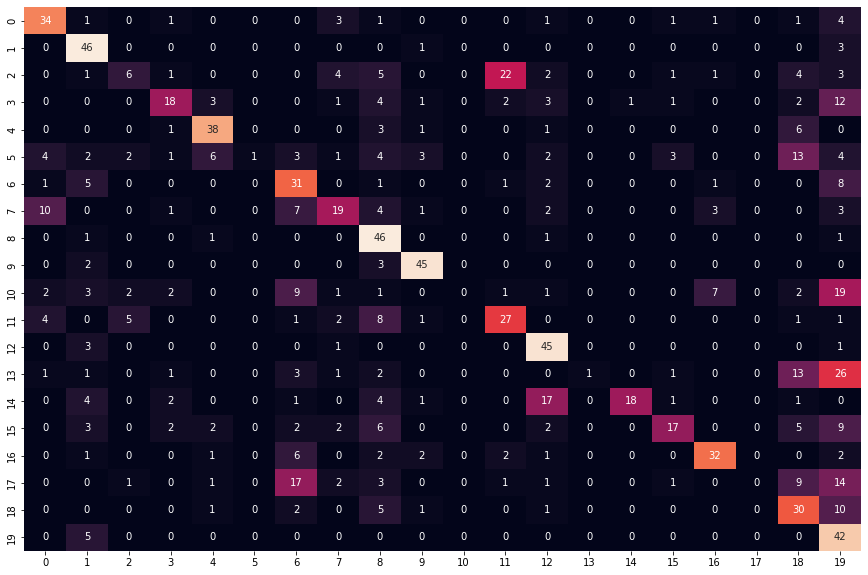

In [35]:
#visualize confusion matrix

import seaborn as sns

cnf_mat = confusion_matrix(validation_generator.classes, Y_pred)

fig,ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(cnf_mat,
                 annot = True,
                 cbar = False)


# Reload the Saved Classifier

In [2]:
# Loading the Model

from tensorflow.keras.models import load_model

classifier = load_model("simpsons_little_vgg.h5")

# Testing the Classifier

In [10]:
#recreating validation generator with shuffle = False
val_data_dir = "./Classifier/simpsons/validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(val_data_dir,
                                                              target_size = (32,32),
                                                              batch_size = 16,
                                                              class_mode = "categorical",
                                                              shuffle = False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k,v in class_labels.items()}

Found 990 images belonging to 20 classes.


In [11]:
class_labels

{0: 'abraham_grampa_simpson',
 1: 'apu_nahasapeemapetilon',
 2: 'bart_simpson',
 3: 'charles_montgomery_burns',
 4: 'chief_wiggum',
 5: 'comic_book_guy',
 6: 'edna_krabappel',
 7: 'homer_simpson',
 8: 'kent_brockman',
 9: 'krusty_the_clown',
 10: 'lenny_leonard',
 11: 'lisa_simpson',
 12: 'marge_simpson',
 13: 'mayor_quimby',
 14: 'milhouse_van_houten',
 15: 'moe_szyslak',
 16: 'ned_flanders',
 17: 'nelson_muntz',
 18: 'principal_skinner',
 19: 'sideshow_bob'}

In [14]:
import os
import cv2
import re
import numpy as np
from tensorflow.keras.preprocessing import image
from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings("ignore")

def draw_test(name, pred, img, true_label):
    BLACK = [0,0,0]
    expanded_im = cv2.copyMakeBorder(img, 160, 0,0,300, cv2.BORDER_CONSTANT,value = BLACK)
    cv2.putText(expanded_im, "predicted - "+pred,(20,60),cv2.FONT_HERSHEY_PLAIN,2,(0,0,255),2)
    cv2.putText(expanded_im, "True -"+true_label,(20,120),cv2.FONT_HERSHEY_PLAIN,2,(0,0,255),2)
    cv2.imshow(name, expanded_im)
    
    
def getRandomImage(path, img_width,img_height):
    
    folders =  list(filter(lambda x: os.path.isdir(os.path.join(path, x)),os.listdir(path)))
    ran_dir = np.random.randint(0, len(folders))
    path_class = folders[ran_dir]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0, len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path+"/"+image_name
    
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path,path_class


img_width, img_height = 32, 32

files = []
predictions = []
true_labels = []


#predicting image

for i in range(0,10):
    path = "./Classifier/simpsons/validation/"
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x , axis = 0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images,batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx = 5, fy = 5, interpolation = cv2.INTER_CUBIC)
    draw_test("prediction",class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)
    
cv2.destroyAllWindows()
    